In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd

In [31]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [33]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
connection = engine.connect()

In [34]:
# create a base
Base = automap_base()

In [35]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# reflect the tables
Base.classes.keys()


['measurement', 'station']

In [36]:
# We can view all of the classes that automap found
inspector = inspect(engine)


In [37]:
# Save references to each table
Measurement = Base.classes.measurement
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [38]:
Station = Base.classes.station
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
title_df = pd.read_sql("SELECT prcp, max(date) as oldest_date FROM measurement", connection)
title_df

,prcp,oldest_date
0,0.0,2017-08-23


In [103]:
# Calculate the date 1 year ago from the last data point in the database
from sqlalchemy import cast, Date
from datetime import datetime
# this is some code i'm trying to get work without manually entering the date
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
# latest_date = session.query(cast(Measurement.date, Date)).order_by(Measurement.date.desc()).first() 

date_1_yr_ago = date.fromisoformat(latest_date)- dt.timedelta(days=365)
date_1_yr_ago
# latest_date[0].split('-')

datetime.date(2016, 8, 23)

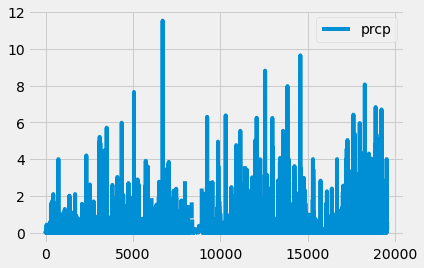

In [121]:
# Perform a query to retrieve the date and precipitation scores
prcp_df = pd.read_sql("SELECT date, prcp FROM measurement", connection)


# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df.set_index('date')

# Sort the dataframe by date
prcp_df.sort_values(by=['date'])
prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()

In [122]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_table = prcp_df.agg({"prcp":["mean","median","var","std","sem"]})
summary_table

,prcp
mean,0.160644
median,0.010000
var,0.219723
std,0.468746
sem,0.003484


In [106]:
# Design a query to show how many stations are available in this dataset?
title_df = pd.read_sql("SELECT DISTINCT station FROM station", connection)
len(title_df)

9

In [131]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
measurement = session.query(Measurement.station, func.count(Measurement.station))\
                .group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# list the number of stations for an internal loop

# loop through the full measurement set to count the number of stations


('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [143]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(Measurement.station, func.min(Measurement.tobs),\
                            func.max(Measurement.tobs), func.round(func.avg(Measurement.tobs),2)).\
                            filter(Measurement.station=='USC00519281').all()
lowest_temp


[('USC00519281', 54.0, 85.0, 71.66)]

In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_stn = session.query(Measurement.tobs, Measurement.date).filter(Measurement.station=='USC00519281').all()
# type(high_stn)
plt.hist(high_stn, bins=12)

(array([[2., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.],
        [2., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [0., 1., 0., ..., 0., 0., 1.]]),
 array([   0. ,  233.5,  467. ,  700.5,  934. , 1167.5, 1401. , 1634.5,
        1868. , 2101.5, 2335. , 2568.5, 2802. ]),
 <a list of 2772 Lists of Patches objects>)

## Bonus Challenge Assignment

In [116]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [149]:
def monthly_normals(month):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.avg(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m", Measurement.date) == month).all()
    
monthly_normals("01")

[(68.72611464968153)]

In [144]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps(date_1_yr_ago, date.fromisoformat(latest_date))


[(58.0, 74.59058295964125, 87.0)]

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title

average_temps_June = session.query(func.avg(Measurement.tobs)).filter(Measurement.date)

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
